In [1]:
import sys; sys.path.append('/Users/omid/Documents/GitHub/Causality/Quantum_RCC/Scripts')
import numpy as np; np.set_printoptions(precision=3, suppress=True) 
import torch as th; import torch; from torch.utils.data import DataLoader; import torch.nn as nn; import torch.nn.functional as F
import pandas as pd; import networkx as nx
import matplotlib.pyplot as plt; import seaborn as sns; sns.set()
from pathlib import Path; import itertools; import os; import random; import time; import copy
import sklearn; from sklearn.model_selection import train_test_split; from sklearn.ensemble import RandomForestClassifier; from sklearn.neural_network import MLPClassifier
import scipy
import ast
import IPython
from sklearn.metrics import confusion_matrix

import rcc_functions as rcc
import utilities_functions as uFun
import channel_functions as chFun
import distance_functions as dFun

In [2]:
split_subsets = ['tr', 'va', 'te']
scenario = 'bi_ce'

### Generate Channel Data

In [3]:
for index_set, subset in enumerate(split_subsets):
    n_samples = [5000, 1000, 1000][index_set]
    n_points = 1000
    n_nodes = 2
    predef_adjacencies_path = None
    
    adjacencies_list = chFun.get_random_adjs(
        scenario=scenario, 
        n_samples=n_samples, 
        predef_adjacencies_path=predef_adjacencies_path,
    )
    
    parameters_list = chFun.get_random_params(
        scenario=scenario, 
        n_samples=n_samples, 
        n_nodes=n_nodes,
    )
    
    pd.DataFrame(parameters_list).to_csv(
        f'../../Data/ch_parameter/{scenario}/{subset}.csv', 
        index=False,
    )
    
    ch_container = chFun.channel_generator(
        adjacencies_list=adjacencies_list, 
        parameters_list=parameters_list, 
        n_points=n_points, 
        saving_path=f'../../Data/ch_container/{scenario}/{subset}.pt',
    )


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

### Build Featurizer
A featuirizer object is used to compute the KME featurizer of given distributions

In [4]:
#n_RandComps=100; data_dim=3; scales = list(np.logspace(-1, +1, 10, False))
n_RandComps=100; data_dim=3; scales = [1]
featurizer_obj=rcc.featurizer(n_RandComps=n_RandComps, scales=scales, data_dim=data_dim)
#uFun.object_saver(featurizer_obj, f'../../Models/{scenario}/kme_featurizer.pkl')
featurizer_obj = uFun.object_loader(f'../../Models/{scenario}/kme_featurizer.pkl')

### Apply the Featurizer to Channel Data

In [5]:
for index_set, subset in enumerate(split_subsets):
    kme_container = rcc.kme_featurizer(
        ch_container_path = f'../../Data/ch_container/{scenario}/{subset}.pt', 
        featurizer_obj    = featurizer_obj, 
        scenario          = scenario,
        quad_labeling     = True,
        saving_path       = f'../../Data/kme_container/{scenario}/{subset}.pt',
    )

### Read KME Datasets

In [6]:
convert_dict = {1:0, 2:1}
x_tr, y_tr = th.load(f'../../Data/kme_container/{scenario}/tr.pt')
x_va, y_va = th.load(f'../../Data/kme_container/{scenario}/va.pt')
x_te, y_te = th.load(f'../../Data/kme_container/{scenario}/te.pt')

y_tr = y_tr.type(th.int64).apply_(lambda v: convert_dict.get(v))
y_va = y_va.type(th.int64).apply_(lambda v: convert_dict.get(v))
y_te = y_te.type(th.int64).apply_(lambda v: convert_dict.get(v))

### Train and Test CLF on KME Datasets

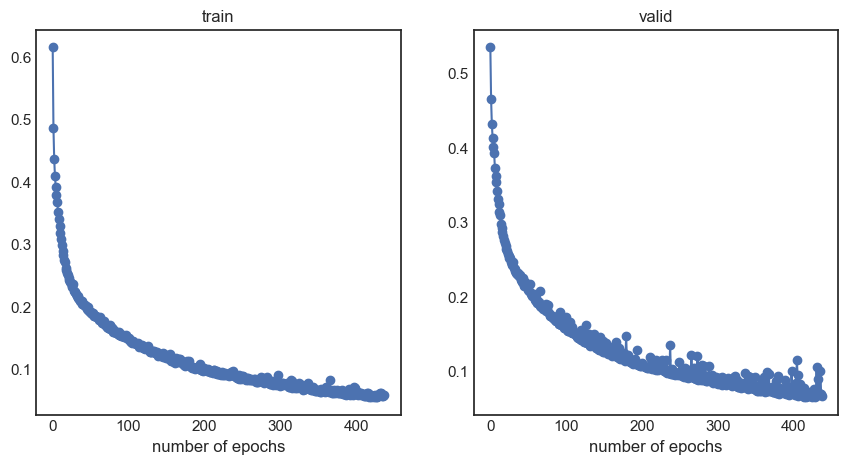

EarlyStopping


In [7]:
clf = uFun.MLPClassifier_torch(
    hidden_layer_sizes=(150,100), 
    batch_size=200, 
    n_epochs=10000,
    patience=10,
    lr=1e-4,
    checkpoint_path=f'../../Models/{scenario}/causal_classifier',
    visualize_progress=True,
    criterion_train = th.nn.CrossEntropyLoss(weight=None),
    criterion_valid = th.nn.CrossEntropyLoss(weight=None),
).fit((x_tr, y_tr), (x_va, y_va))

th.save(clf, f'../../Models/{scenario}/causal_classifier')

In [8]:
clf = th.load(f'../../Models/{scenario}/causal_classifier')
y_true = y_te.numpy()
y_pred = clf.predict(x_te).detach().numpy()
confusion = confusion_matrix(y_true, y_pred, labels=[0,1], normalize='true')
confusion

array([[0.971, 0.029],
       [0.026, 0.974]])

### Visualize Performance

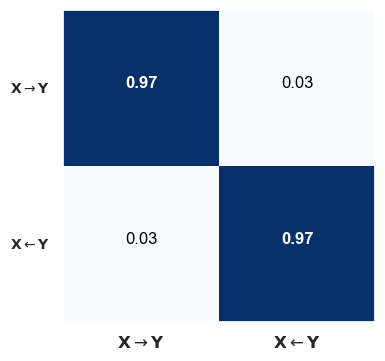

In [9]:
sns.set_style("dark")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), tight_layout=True)
uFun.plot_confusion(ax, confusion, [0, 1], fontsize=None)
plt.show()
plt.close()